# Spatial interpolation

In your life as a spatial data scientist, you will find yourself in a
situation where you have plenty of data to work with, just linked to
different geometries or representing slightly different locations that
you need. When this happens, you need to *interpolate* the data from one
set of geometries, on which the data is shipped, to the other, the one
you are interested in.

Any interpolation method is necessarily an approximation but some are
better than others.

In [6]:
import geopandas as gpd
import tobler
import pyinterpolate
import numpy as np
import matplotlib.pyplot as plt

from libpysal import graph
from sklearn import neighbors
from scipy import interpolate

This chapter of the course covers two types of interpolation - from one
set of polygons to another set of polygons, and from a sparse set of
points to other locations in the same area.

## Areal interpolation and dasymetric mapping

The first use case is the interpolation of data from one set of
geometries to the other one, otherwise known as *areal interpolation* or
*dasymetric mapping*.

### Data zones and H3

You are already familiar with the Scottish Index of Multiple
Deprivation, so let’s use it as an example of areal interpolation. Load
the subset of SIMD 2020 for the City of Edinburgh.

In [7]:
simd = gpd.read_file(
    "https://martinfleischmann.net/sds/interpolation/data/edinburgh_simd_2020.gpkg"
)
simd.head(2)

,DataZone,DZName,LAName,SAPE2017,WAPE2017,Rankv2,Quintilev2,Decilev2,Vigintilv2,Percentv2,...,CrimeRate,CrimeRank,HouseNumOC,HouseNumNC,HouseOCrat,HouseNCrat,HouseRank,Shape_Leng,Shape_Area,geometry
0,S01008417,Balerno and Bonnington Village - 01,City of Edinburgh,708,397,5537,4,8,16,80,...,86,5392.0,17,8,2%,1%,6350.0,20191.721420,1.029993e+07,"POLYGON ((315157.369 666212.846, 315173.727 66..."
1,S01008418,Balerno and Bonnington Village - 02,City of Edinburgh,691,378,6119,5,9,18,88,...,103,5063.0,7,10,1%,1%,6650.0,25944.861787,2.357050e+07,"POLYGON ((317816 666579, 318243 666121, 318495..."


> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/interpolation/data/edinburgh_simd_2020.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> simd = gpd.read_file(
>     "edinburgh_simd_2020.gpkg",
> )
> ```

Get an interactive map with one of the variables to get more familiar
with the data.

In [ ]:
simd[["EmpNumDep", "geometry"]].explore("EmpNumDep", tiles="CartoDB Positron")

This is the source - data linked to SIMD Data Zones. Let’s now focus on
the target geometries. Popular spatial units of analysis are hexagonal
grids and Uber’s hierarchical H3 grid especially.

> **More on H3**
>
> H3 grids are a very interesting concept as they often allow for very
> efficient spatial operations based on known relationships between
> individual cells (encoded in their index). Check the [official
> documentation](https://h3geo.org) if you want to learn more.
>
> Pay specific attention to the meaning of the
> [resolution](https://h3geo.org/docs/core-library/restable#cell-areas).

You can create the H3 grid covering the area of Edinburgh using the
`tobler` package.

In [9]:
grid_8 = tobler.util.h3fy(simd, resolution=8)
grid_8.head(2)

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pyproj\crs\crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


,geometry
hex_id,
8819727747fffff,"POLYGON ((317597.796 677539.053, 317133.791 67..."
8819727663fffff,"POLYGON ((322161.329 675567.266, 321697.55 675..."


Let’s check how the H3 grid overlaps the data zones of SIMD.

In [ ]:
m = simd.boundary.explore(tiles="CartoDB Positron")
grid_8.boundary.explore(m=m, color="red")

Some grid cells are fully within a data zone geometry, some data zones
are fully within a single grid cell but overall, there is a lot of
partial overlap.

### tobler and Tobler

The task ahead can be done in many ways falling under the umbrella of
dasymetric mapping. PySAL has a package designed for areal interpolation
called `tobler`. You have already used it to create the H3 grid but that
is only a small utility function included in `tobler`. The name of the
package is a homage to the Waldo R. Tobler, a famous geographer and an
author of a Pycnophylactic interpolation covered below

### Simple areal interpolation

But before getting to the Pycnophylactic interpolation, let’s start with
the simple case of basic areal interpolation. The logic behind it is
quite simple - the method redistributes values from the source
geometries to target geometries based on the proportion of area that is
shared between each source polygon and each target polygon. It is not a
simple join as you would get with `sjoin()` or `overlay()` methods from
`geopandas` but it is not far from it. Areal interpolation brings an
additional step of taking the values and redistributing them instead of
merging. That means that if the source geometry contains a count of 10
people and 40% of the geometry is covered by a target polygon A, 40% by
a target polygon B and 20% by a target polygon C, each gets a relevant
proportion of the original count (4, 4, and 2). Similarly are treated
intensive variables (e.g. a percentage).

The function you need to use for this kind of areal interpolation lives
in the `area_weighted` module of `tobler` and is called simply
`area_interpolate`. Use it to interpolate a subset of data from `simd`
to `grid_8`.

In [11]:
interpolated = tobler.area_weighted.area_interpolate(
    source_df=simd,
    target_df=grid_8,
    extensive_variables=["EmpNumDep", "IncNumDep"],
    intensive_variables=["EmpRate", "IncRate"],
)
interpolated.head(2)

,EmpNumDep,IncNumDep,EmpRate,IncRate,geometry
hex_id,,,,,
8819727747fffff,1.382178,3.846060,3.000000,5.000000,"POLYGON ((317597.796 677539.053, 317133.791 67..."
8819727663fffff,182.736975,408.170105,7.903459,10.897692,"POLYGON ((322161.329 675567.266, 321697.55 675..."


The resulting `interpolated` `GeoDataFrame` contains the selected
variables from `simd` but linked to the `grid_8` geometries. You can
check the result on a map and compare it to the one above.

In [ ]:
interpolated.explore("EmpNumDep", tiles="CartoDB Positron")

> **Raster masking**
>
> You may have noticed that even if the actual location where a grid
> cell lies does not contain any buildings, it gets a proportion of data
> based on the area of overlap. That may not be an issue in some cases
> but if you want to be more precise, you can use a raster layer as a
> mask to further influence the redistribution of values. See the
> [documentation](https://pysal.org/tobler/notebooks/01_interpolation_methods_overview.html#Model-Based-Interpolation)
> for details.

### Pycnophylactic interpolation

Another option is to use Pycnophylactic interpolation
\[@tobler1979smooth\], a method that creates a smooth contour map of the
original data while preserving the volume but avoiding sharp boundaries
and uses this to interpolate values onto the target polygons. Unlike
`area_interpolate`, `pycno_interpolate` does not handle intensive
variables.

In [13]:
pycno_8 = tobler.pycno.pycno_interpolate(
    source_df=simd,
    target_df=grid_8,
    variables=["EmpNumDep", "IncNumDep"],
    cellsize=200,
)

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  correct = (val - nansum(data[mask])) / mask.sum()
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  correct = val / nansum(data[mask])
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  correct = (val - nansum(data[mask])) / mask.sum()
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  correct = val / nansum(data[mask])
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:145: RuntimeWarni

From the user perspective, both `area_interpolate` and
`pycno_interpolate` look similar but the results will likely differ.

In [ ]:
pycno_8.explore("EmpNumDep", tiles="CartoDB Positron")

For a better understanding of the method, you can look at the
intermediate array of smoothed values by accessing the `pycno` function
from the depth of the `tobler.pycno` module.

In [15]:
arr, _, _ = tobler.pycno.pycno.pycno(
    gdf=simd, value_field="EmpNumDep", cellsize=200, verbose=False
)

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  correct = (val - nansum(data[mask])) / mask.sum()
c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\tobler\pycno\pycno.py:145: RuntimeWarning: divide by zero encountered in scalar divide
  correct = val / nansum(data[mask])


The function returns a numpy array of smoothed values and two pieces of
information related to CRS, that are not relevant here. The array itself
can be explored directly using `matplotlib`:

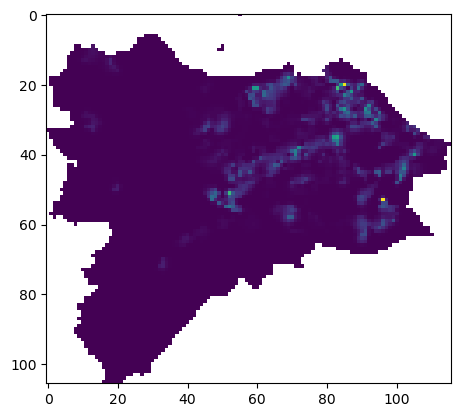

In [16]:
_ = plt.imshow(arr)

> **Theory behind**
>
> For more details on the theory behind both areal and Pycnophylactic
> interpolation methods, check [this
> resource](https://gistbok.ucgis.org/bok-topics/2022-quarter-04/areal-interpolation)
> by @comber2022areal.

## Point interpolation

Another case of *interpolation* is an interpolation of values from a
sparse set of points to any other location in between. Let’s explore our
options based on the Airbnb data in Edinburgh.

### Airbnb in Edinburgh

You are already familiar with the Airbnb data from the [Is there a
pattern?](../point_patterns/exercise.qmd) exercise. The dataset for
Edinburgh looks just like that for Prague you used before. The only
difference is that, for this section, it is pre-processed to create
geometry and remove unnecessary columns.

In [17]:
airbnb = gpd.read_file(
    "https://martinfleischmann.net/sds/interpolation/data/edinburgh_airbnb_2023.gpkg"
)
airbnb.head()

,id,bedrooms,property_type,price,geometry
0,15420,1.0,Entire rental unit,$126.00,POINT (325921.137 674478.931)
1,790170,2.0,Entire condo,$269.00,POINT (325976.36 677655.252)
2,24288,2.0,Entire loft,$95.00,POINT (326069.186 673072.913)
3,821573,2.0,Entire rental unit,$172.00,POINT (326748.646 674001.683)
4,822829,3.0,Entire rental unit,$361.00,POINT (325691.831 674328.127)


> **Alternative**
>
> Instead of reading the file directly off the web, it is possible to
> download it manually, store it on your computer, and read it locally.
> To do that, you can follow these steps:
>
> 1.  Download the file by right-clicking on [this
>     link](https://martinfleischmann.net/sds/interpolation/data/edinburgh_airbnb_2023.gpkg)
>     and saving the file
> 2.  Place the file in the same folder as the notebook where you intend
>     to read it
> 3.  Replace the code in the cell above with:
>
> ``` python
> airbnb = gpd.read_file(
>     "edinburgh_airbnb_2023.gpkg",
> )
> ```

You will be focusing on the price of each listing. Let’s check that
column.

In [18]:
airbnb.price.head()

0    $126.00
1    $269.00
2     $95.00
3    $172.00
4    $361.00
Name: price, dtype: object

While the values represent numbers, they are encoded as strings starting
with the `$` sign. That will not work for any interpolation (or any
other mathematical method). Use `pandas` to strip the string of the `$`
character, remove `,` and cast the remaining to `float`.

In [19]:
airbnb["price_float"] = (
    airbnb.price.str.strip("$").str.replace(",", "").astype(float)
)

That is set now, you have numbers as expected. Since the dataset
represents all types of Airbnb listings, it may be better to select only
one type. Filter out only those with 2 bedrooms that can be rented as
the whole flat and have a price under £300 per night (there are some
crazy outliers).

In [20]:
two_bed_homes = airbnb[
    (airbnb["bedrooms"] == 2)
    & (airbnb["property_type"] == "Entire rental unit")
    & (airbnb["price_float"] < 300)
].copy()
two_bed_homes.head()

,id,bedrooms,property_type,price,geometry,price_float
3,821573,2.0,Entire rental unit,$172.00,POINT (326748.646 674001.683),172.0
5,834777,2.0,Entire rental unit,$264.00,POINT (324950.724 673875.598),264.0
6,450745,2.0,Entire rental unit,$177.00,POINT (326493.725 672853.904),177.0
10,485856,2.0,Entire rental unit,$157.00,POINT (326597.124 673869.551),157.0
17,51505,2.0,Entire rental unit,$155.00,POINT (325393.807 674177.409),155.0


Another useful check before heading to the land of interpolation is for
duplicated geometries. Having two points at the same place, each with a
different value could lead to unexpected results.

In [21]:
two_bed_homes.geometry.duplicated().any()

True

There are some duplicated geometries. Let’s simply drop rows with
duplicated locations and keep only the first occurrence (the default
behaviour of `drop_duplicates`).

In [22]:
two_bed_homes = two_bed_homes.drop_duplicates("geometry")

Check how the cleaned result looks on a map.

In [ ]:
two_bed_homes.explore("price_float", tiles="CartoDB Positron")

There are some visible patterns of higher and lower prices, but it may
be tricky to do interpolation since the data is a bit too chaotic. In
general, point interpolation methods work only when there is a spatial
autocorrelation in the data and stronger autocorrelation leads to better
interpolation. As you know, spatially lagged variable of already
autocorrelated variable shows higher levels of autocorrelation, hence
using the spatial lag will be beneficial for this section.

In [ ]:
knn = graph.Graph.build_kernel(two_bed_homes, k=10).transform("r")
two_bed_homes["price_lag"] = knn.lag(two_bed_homes.price_float)
two_bed_homes.explore("price_lag", tiles="CartoDB Positron")

This looks much better. Let’s start with some interpolation. Create
another H3 grid, this time with a resolution of 10 (much smaller cells
than before). You will use it as a target of interpolation.

In [25]:
grid_10 = tobler.util.h3fy(simd, resolution=10)

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\pyproj\crs\crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


All of the methods below do not expect geometries as an input, but
arrays of coordinates. That is an easy task. An array from the grid can
be extracted from the centroid of each cell:

In [26]:
grid_coordinates = grid_10.centroid.get_coordinates()
grid_coordinates.head()

,x,y
hex_id,,
8a1972766aeffff,322636.375855,675368.671597
8a1972760b97fff,323763.849016,674100.634942
8a197275a46ffff,312904.267590,665282.653201
8a197276158ffff,323698.967943,672506.677364
8a197239e867fff,330724.701647,668911.272625


And an array from the Airbnb subset can be retrieved directly from point
data:

In [27]:
homes_coordinates = two_bed_homes.get_coordinates()
homes_coordinates.head()

,x,y
3,326748.645636,674001.683211
5,324950.723888,673875.598033
6,326493.725178,672853.903917
10,326597.123684,673869.551295
17,325393.807222,674177.408961


### Nearest

The simplest case is the *nearest* interpolation. That assigns a value
to a given point based on the value of the nearest point in the original
dataset. You can use the `griddata` function from the
`scipy.interpolate` module to do that efficiently.

In [28]:
nearest = interpolate.griddata(
    points=homes_coordinates,
    values=two_bed_homes.price_lag,
    xi=grid_coordinates,
    method="nearest",
)
nearest

array([156.29884005, 174.69562676, 181.        , ..., 188.70398583,
       188.70398583,  84.        ])

The result is provided as a `numpy.ndarray` object aligned with
`grid_coordinates`, so you can directly assign it as a column.

In [29]:
grid_10["nearest"] = nearest

Check the result of the nearest interpolation on a map.

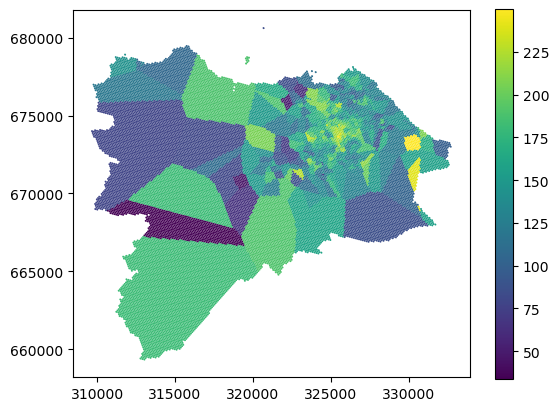

In [30]:
_ = grid_10.plot('nearest', legend=True)

You can see that the result is actually a Voronoi tessellation. If you
plot the original points on top, it is even clearer.

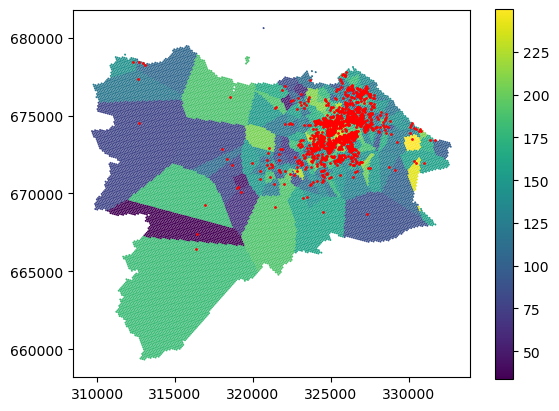

In [31]:
ax = grid_10.plot('nearest', legend=True)
_ = two_bed_homes.plot(ax=ax, color="red", markersize=1)

Nearest interpolation may be fine for some use cases, but it is not a
good interpolation method in general.

### K-nearest neighbours regression

Expanding the nearest method, which takes a single nearest neighbour and
allocates the values, you can use the K-nearest neighbours regression
(KNN) method. KNN takes into account multiple nearest neighbours and
interpolates the value based on all of them.

#### Uniform

The simple KNN option is to find $K$ nearest neighbours (say 10), treat
all equally (uniform weights), and obtain the interpolated value as a
mean of values these neighbours have. The implementation of KNN is
available in `scikit-learn`, so it has the API you are already familiar
with from the [Clustering and
regionalisation](../clustering/hands_on.qmd) section.

In [32]:
interpolation_uniform = neighbors.KNeighborsRegressor(
    n_neighbors=10, weights="uniform"
)

As with the clustering, use the `fit()` method to *train* the object.

In [33]:
interpolation_uniform.fit(
    homes_coordinates, two_bed_homes.price_lag
)

KNeighborsRegressor(n_neighbors=10)

Once the model is ready, you can *predict* the values on the grid
coordinates.

In [34]:
price_on_grid = interpolation_uniform.predict(grid_coordinates)
price_on_grid

array([125.5214288 , 162.30376507,  93.47717891, ..., 120.36697169,
       120.36697169, 120.36697169])

This is, again, a `numpy.ndarray` that is aligned and can be directly
set as a column.

In [35]:
grid_10["knn_uniform"] = price_on_grid

Check the result on a map.

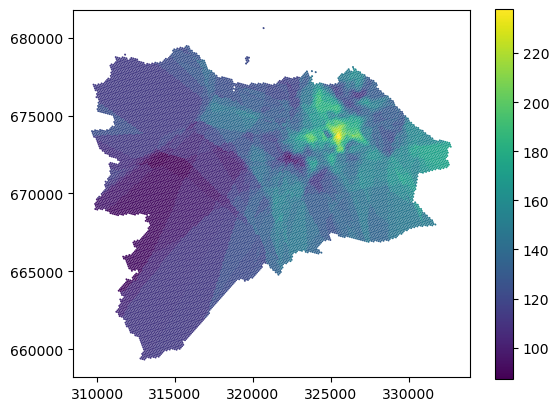

In [36]:
_ = grid_10.plot("knn_uniform", legend=True)

This is already much better than the simple nearest join based on a
single neighbor but there are still a lot of artefacts in the areas
where you have only a few points far away from each other.

> **Using `KNeighborsRegressor` for the nearest join**
>
> You have probably figured out that you don’t need
> `scipy.interpolate.griddata` to do the nearest join if you have access
> to `sklearn.neighbors.KNeighborsRegressor`. With `n_neighbors=1`, the
> result should be the same. However, there are situations when only one
> is available, so it is good to know your options.

#### Distance-weighted

One way to mitigate the artefacts and take geography a bit more into the
equation is to use distance-weighted KNN regression. Instead of treating
each neighbour equally, no matter how far from the location of interest
they are, you can weigh the importance of each by distance, or to be
more precise, by the inverse of the distance. This ensures that points
that are closer and considered more important for the interpolation than
those that are further away.

In [37]:
interpolation_distance = neighbors.KNeighborsRegressor(
    n_neighbors=10, weights="distance"
)

The only difference is in the `weight` argument. The rest is the same.

In [38]:
interpolation_distance.fit(
    homes_coordinates, two_bed_homes.price_lag
)

KNeighborsRegressor(n_neighbors=10, weights='distance')

Train the model, predict the values for the grid and assign to the
`GeoDataFrame`.

In [39]:
grid_10["knn_distance"] = interpolation_distance.predict(grid_coordinates)

If you look at the resulting map, you can see that most of the artefacts
are gone.

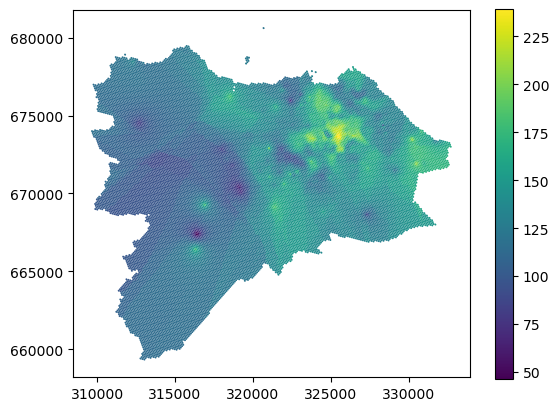

In [40]:
_ = grid_10.plot("knn_distance", legend=True)

### Distance band regression

Distance can be employed in another way as well. Instead of selecting
the neighbours from which the values are interpolated based on K-nearest
neighbours, you can select them based on distance. For example, find all
points in a radius of 1000 metres around a location of interest and draw
the interpolated value from them. You can also further weigh these
neighbours using the inverse distance. The code looks nearly identical.
Just use `neighbors.RadiusNeighborsRegressor` instead of
`neighbors.KNeighborsRegressor`.

In [41]:
interpolation_radius = neighbors.RadiusNeighborsRegressor(
    radius=1000, weights="distance"
)
interpolation_radius.fit(
    homes_coordinates, two_bed_homes.price_lag
)

grid_10["radius"] = interpolation_radius.predict(grid_coordinates)

c:\Computation\Scripts\Packages\sds-zapletalj-cze\.pixi\envs\default\Lib\site-packages\sklearn\neighbors\_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Check the result. The issue with sparsely populated areas on the map is
a bit different this time. When there is no neighbour in 1000m, the
model is not able to produce any prediction and returns `np.nan`. This
may be seen as an issue but it can actually be a strength of the model
as it is upfront with the issues caused by sparsity. Note that the model
warns you about this situation during the prediction phase.

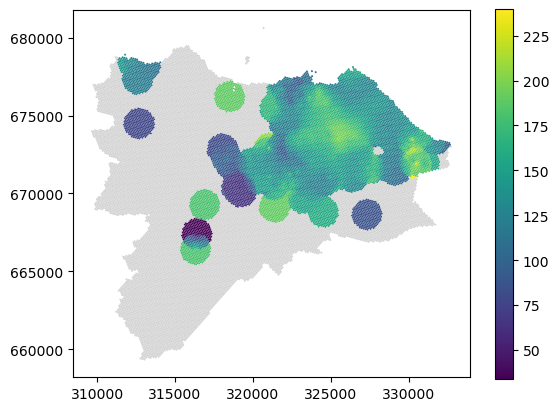

In [42]:
_ = grid_10.plot("radius", legend=True, missing_kwds={'color': 'lightgrey'})

### Ordinary Kriging

The final method of this section is ordinary kriging. Kriging is based
on a linear combination of observations that are nearby, like all the
cases above, but the model is more complex and takes into account
geographical proximity, but also the spatial arrangement of observations
and the pattern of autocorrelation. As such, it can be seen as the most
robust of the presented options.

You will use the package `pyinterpolate` to do kriging. It requires all
input data in a single `numpy.ndarray` composed of coordinates and
values.

In [43]:
input_data = np.hstack(
    [homes_coordinates, two_bed_homes.price_lag.values.reshape(-1, 1)]
)
input_data

array([[3.26748646e+05, 6.74001683e+05, 2.07033397e+02],
       [3.24950724e+05, 6.73875598e+05, 1.54805935e+02],
       [3.26493725e+05, 6.72853904e+05, 1.43865293e+02],
       ...,
       [3.28513265e+05, 6.74048892e+05, 1.06875409e+02],
       [3.26840903e+05, 6.74767224e+05, 1.68848108e+02],
       [3.25415664e+05, 6.73345158e+05, 2.15847334e+02]])

The `input_data` is now an array `pyinterpolate` expects. The first step
is to build an experimental variogram based on the data and a couple of
parameters.

In [44]:
exp_semivar = pyinterpolate.build_experimental_variogram(
    input_array=input_data,
    step_size=100,
    max_range=5000,
)

The result can be plotted and explored using the `plot()` method. The
experimental variogram is a plot that shows how the semivariance between
pairs of sample points changes with distance. The variogram is
calculated by taking pairs of sample points and computing the
semivariance of the differences in their values at different distances.
It measures the degree of relationship between points at different
distances. Semivariance is half the variance of the differences in
values between pairs of points at a set distance.

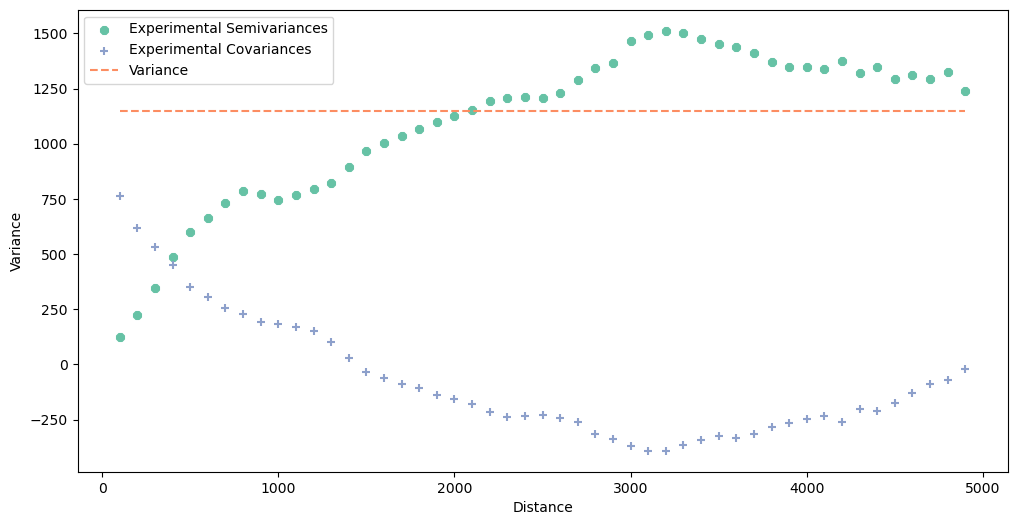

In [45]:
exp_semivar.plot()

Next, you need to build a theoretical semivariogram based on the
experimental variogram.

In [46]:
semivar = pyinterpolate.build_theoretical_variogram(
    experimental_variogram=exp_semivar,
    model_name='spherical',
    sill=exp_semivar.variance,
    rang=5000,
)

Again, you can plot the result. The theoretical variogram is a model or
a mathematical function that is fitted to the experimental variogram.

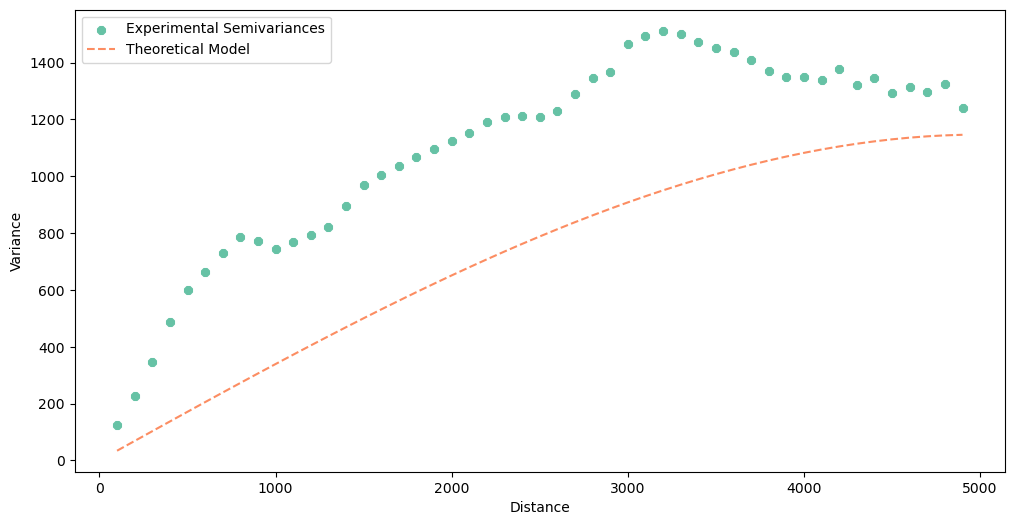

In [47]:
semivar.plot()

You can see that the linear model does not precisely follow the
experimental semivariances. Let’s try another option.

In [48]:
semivar_spherical = pyinterpolate.build_theoretical_variogram(
    experimental_variogram=exp_semivar,
    model_name='cubic',
    sill=exp_semivar.variance,
    rang=2500,
    nugget=3,
)

Let’s see if it is a bit better.

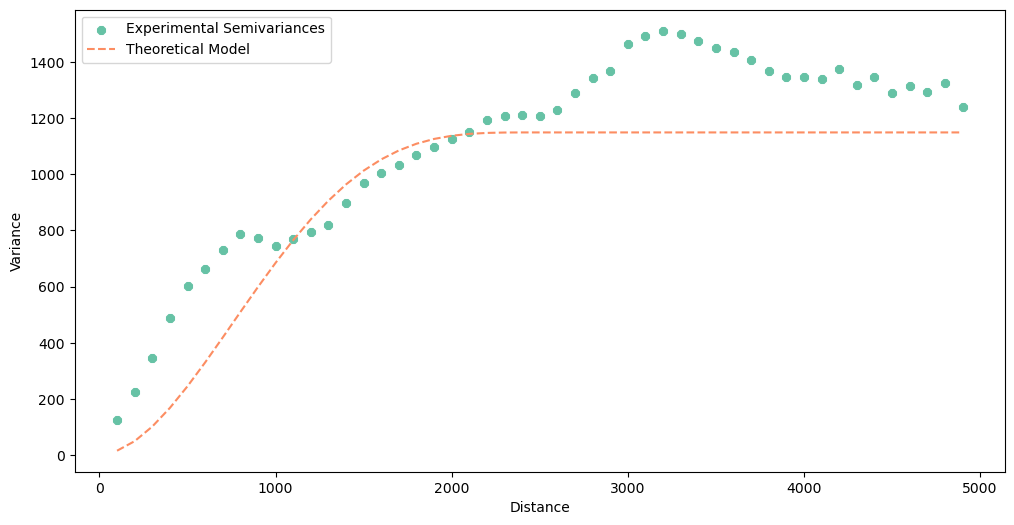

In [49]:
semivar_spherical.plot()

Now you are ready to use kriging to interpolate data on your grid.

In [50]:
ordinary_kriging = pyinterpolate.kriging(
    observations=input_data,
    theoretical_model=semivar_spherical,
    points=grid_coordinates.values,
    how="ok",
    no_neighbors=10,
    show_progress_bar=True,
)


100%|██████████| 20162/20162 [00:04<00:00, 4277.33it/s]


The resulting `ordinary_kriging` is a numpy.ndarray with four columns
representing predicted value, variance error, x, and y. You can select
the first one and assign it as a column.

In [51]:
grid_10["ordinary_kriging"] = ordinary_kriging[:, 0]

And check the result.

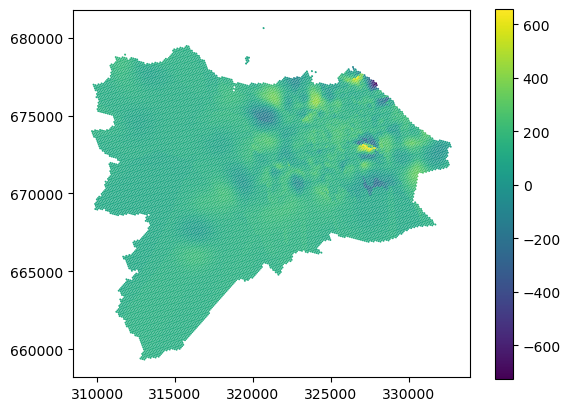

In [52]:
_ = grid_10.plot("ordinary_kriging", legend=True)

Ordinary kriging looks great in dense areas but shows yet another type
of artefact in sparse areas. While there are ways to mitigate the issue
by changing the radius and other parameters of the model, it is worth
noting that the reliability of any interpolation method in sparsely
populated areas (in terms of the density of original points) is
questionable. Kriging has a method to indicate the error rate using the
variance error, which may help assess the issue. Variance error is the
second column of the `ordinary_kriging` array.

In [ ]:
grid_10["variance_error"] = ordinary_kriging[:, 1]
_ = grid_10.plot("variance_error", legend=True)

You can see from the plot of variance error that anything further away
from existing points becomes fairly unreliable. You can, for example,
set the specific threshold of the variance error you think is acceptable
and treat all the other locations as *missing* or *unreliable*.

> **Check the effect of the theoretical semivariogram model**
>
> Explore the difference between kriging using linear and spherical
> models in theoretical semivariograms. What are the other options and
> their effects?

> **Additional reading**
>
> Have a look at the chapter [*Spatial Feature
> Engineering*](https://geographicdata.science/book/notebooks/12_feature_engineering.html?highlight=interpol#area-to-area-interpolation)
> from the Geographic Data Science with Python by @rey2023geographic to
> learn a bit more about areal interpolation or look at the [Areal
> Interpolation](https://gistbok.ucgis.org/bok-topics/2022-quarter-04/areal-interpolation)
> topic of The Geographic Information Science & Technology Body of
> Knowledge by @comber2022areal. The same source also contains a nice
> [explanation of
> kriging](https://gistbok.ucgis.org/bok-topics/kriging-interpolation)
> by @goovaerts2019kriging.